In [1]:
from common.ETLBase import PipelineBuilder

- Allow visualization of configuration 

In [2]:
from pyflow import GraphBuilder
pipe = PipelineBuilder()

In [3]:
def one_two():
    return 5, 2
def test(b=2):
    return b + 1

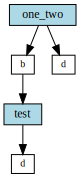

In [4]:
b, d = pipe.add(one_two, output_alias=['b', 'd'], n_out = 2)()
d = pipe.add(test, output_alias = 'd')(b=b)
pipe.view(summary=False)

In [5]:
d.get()

6

In [6]:
b.pf_output_node

<weakref at 0x7f5446b756e0; to 'DataNode' at 0x7f54403457d0>

In [7]:
from common.ETLBase import DataNode
# if kwargs has the following type of objects, replace them with .pf_output_node 
type(b).__name__ == 'DataNode+ETLBase'
type(b).__name__ == 'SelectResult+ETLBase'

True

# Functions

In [8]:
from experiments.ex3.preprocess_modules import *

# Build Pipeline 

In [9]:
import os
origin_path = 'data/source'
sample_path = 'data/sample'

tmp_path = 'data/tmp' # 'data/tmp'
result_path = 'data/result' # 'data/result'

chid_file = os.path.join(origin_path, 'sample_chid.txt')
cdtx_file = os.path.join(origin_path, 'sample_zip_if_cca_cdtx0001_hist.csv')
cust_f_file = os.path.join(origin_path, 'sample_zip_if_cca_cust_f.csv')

# ETL configuration >

# easily assign configuration using 'Config Builder Object' 
# it initialize using pipe_config = PipeConfigBuilder()
# add config variable using var = pipe_config.add(name='var', value=50)
# 
n_sample = 50
window_size = 120 
test_size = 2

category_cols = ['chid', 'bnsfg', 'iterm', 'mcc', 'scity'] # ETL Variable 
numeric_cols = ['bnspt', 'timestamp_0', 'timestamp_1', 'objam'] # ETL Variable 


LEFT = 'left'
INNER ='inner'
time_column_data_dt = 'data_dt'
time_column_csmdt = 'csmdt'
result_column_timestamp_1 = 'timestamp_1'
result_column_timestamp_0 = 'timestamp_0'
result_column_timestamp = 'timestamp'

cust_numeric_cols = ['slam', 'first_mob', 'constant_change', 'sum_l2_ind',
                  'sum_u2_ind', 'constant_l2_ind', 'constant_u4_ind',
                  'growth_rate', 'monotone_down', 'monotone_up', 'data_dt']
cust_category_cols = ['chid', 'masts', 'educd', 'trdtp', 'poscd']
target_cols = ['chid', 'data_dt', 'objam_sum', 'objam_mean', 'trans_count', 'objam_mean_M3']

# < ETL configuration

sparse_feat = ['chid', 'bnsfg', 'iterm', 'mcc', 'scity']
dense_feat = ['bnspt', 'timestamp_0', 'timestamp_1', 'objam']
USE_CHID = True

sparse_dense_setting_generator = GenerateSparseDenseSetting(
    category_cols=category_cols, 
    sparse_feat=sparse_feat, 
    numeric_cols=numeric_cols, 
    dense_feat=dense_feat, 
    USE_CHID=USE_CHID
)

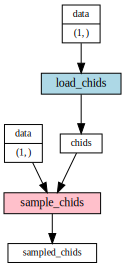

In [10]:
pipe = PipelineBuilder()
chids = pipe.add(load_chids, output_alias = 'chids')(chid_file = chid_file)

sampled_chids = pipe.add(
    sample_chids, 
    output_alias = 'sampled_chids', 
    result_dir = os.path.join(sample_path,'sampled_chids.npy')
)(chids, n_sample = n_sample)
pipe.view(summary = False)

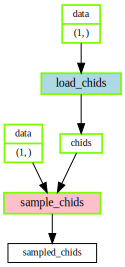

In [11]:
pipe.view_dependency('sample_chids', summary=False)

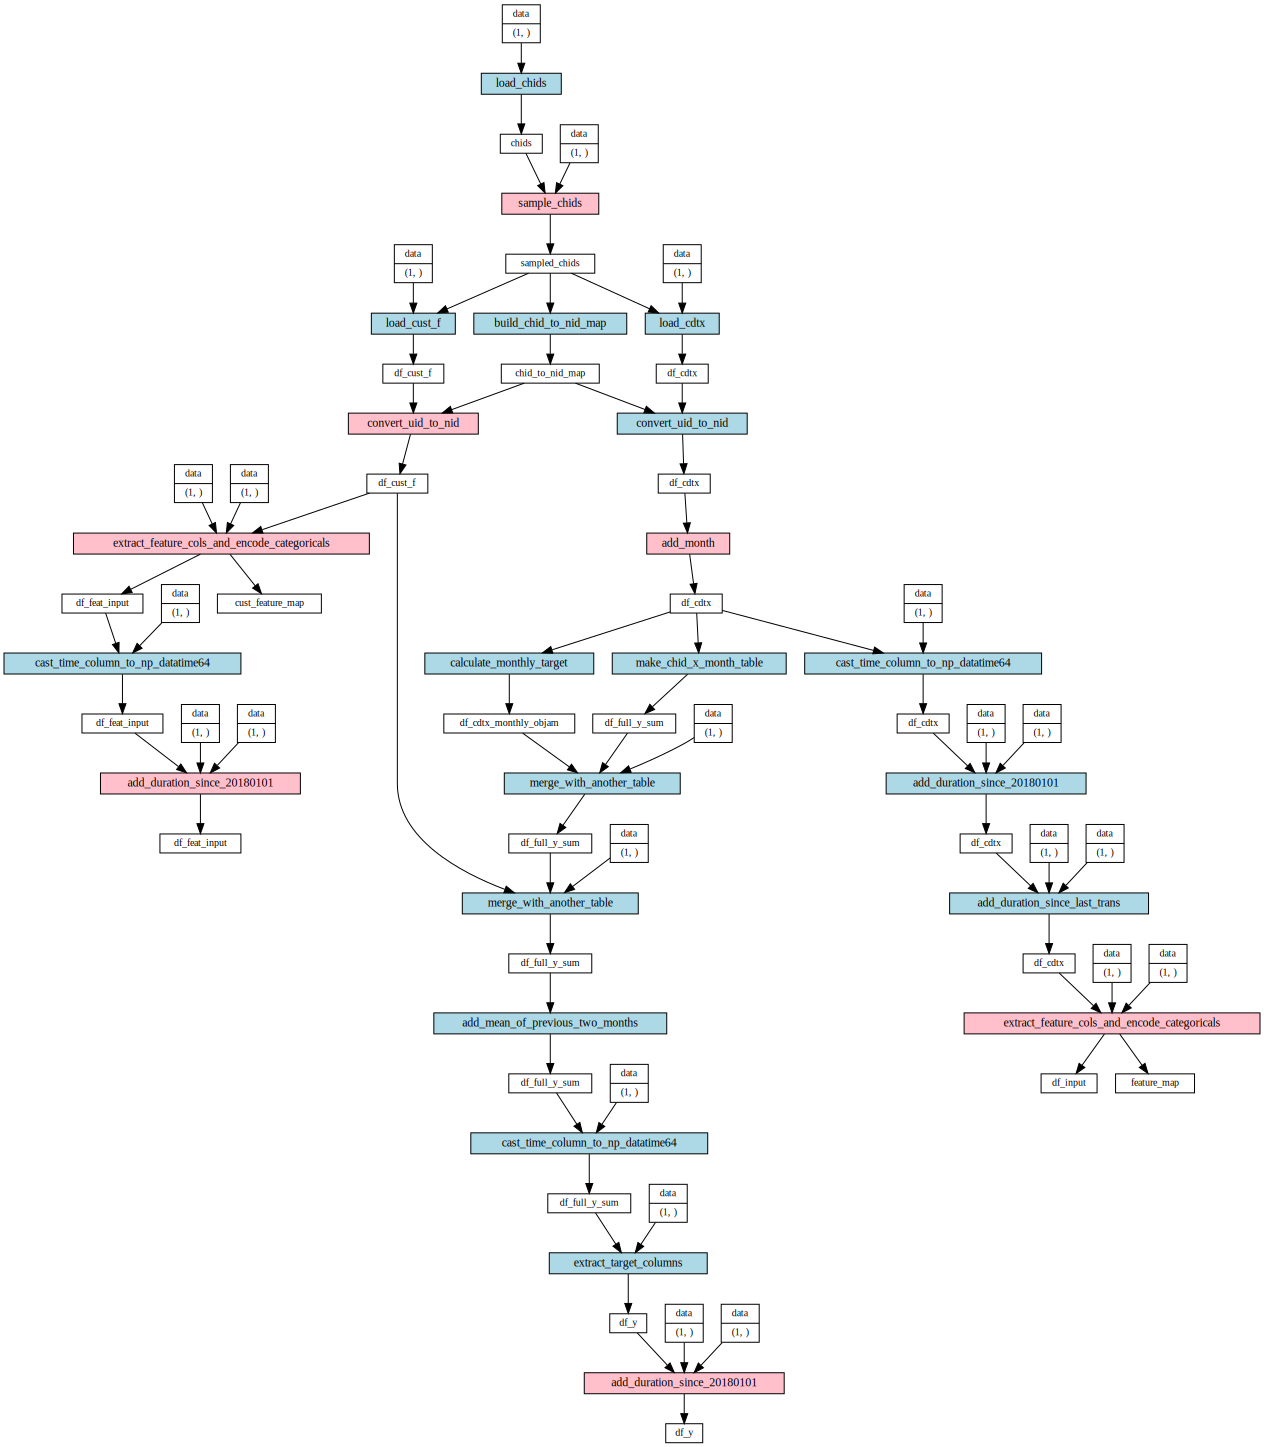

In [12]:
chid_to_nid_map = pipe.add(build_chid_to_nid_map, output_alias = 'chid_to_nid_map')(
    sampled_chids
)
df_cdtx = pipe.add(load_cdtx, output_alias = 'df_cdtx')(
    sampled_chids, 
    cdtx_file = cdtx_file
)
df_cdtx = pipe.add(convert_uid_to_nid, output_alias = 'df_cdtx')(
    df_cdtx, 
    chid_to_nid_map
)
df_cdtx = pipe.add(add_month, 
                 output_alias = 'df_cdtx', 
                 result_dir = os.path.join(tmp_path, 'df_cdtx.feather')
                )(df_cdtx)

df_full_y_sum = pipe.add(
    make_chid_x_month_table, 
    output_alias = 'df_full_y_sum'
)(
    df_cdtx
)

df_cdtx_monthly_objam = pipe.add(calculate_monthly_target, output_alias = 'df_cdtx_monthly_objam')(
    df_cdtx
)

df_full_y_sum = pipe.add(merge_with_another_table, output_alias = 'df_full_y_sum')(
    df_full_y_sum, 
    df_cdtx_monthly_objam, 
    join_method=LEFT
)



df_cust_f = pipe.add(load_cust_f, output_alias = 'df_cust_f')(
    sampled_chids, 
    cust_f_file = cust_f_file
)

df_cust_f = pipe.add(
    convert_uid_to_nid, 
    output_alias = 'df_cust_f', 
    result_dir = os.path.join(tmp_path, 'df_cust_f.feather')
)(
    df_cust_f, 
    chid_to_nid_map
)

df_full_y_sum = pipe.add(merge_with_another_table, output_alias = 'df_full_y_sum')(
    df_full_y_sum, df_cust_f, join_method=INNER)



df_full_y_sum = pipe.add(add_mean_of_previous_two_months, output_alias = 'df_full_y_sum')(
    df_full_y_sum)



df_full_y_sum = pipe.add(cast_time_column_to_np_datatime64, output_alias = 'df_full_y_sum')(
    df_full_y_sum, time_column = time_column_data_dt)



df_cdtx = pipe.add(cast_time_column_to_np_datatime64, output_alias = 'df_cdtx')(
    df_cdtx, time_column = time_column_csmdt)




df_cdtx = pipe.add(add_duration_since_20180101, output_alias = 'df_cdtx')(
    df_cdtx, time_column = time_column_csmdt, result_column=result_column_timestamp_1)


df_cdtx = pipe.add(add_duration_since_last_trans, output_alias = 'df_cdtx')(
    df_cdtx, time_column = time_column_csmdt, result_column=result_column_timestamp_0)


df_input, feature_map = pipe.add(
    extract_feature_cols_and_encode_categoricals, 
    n_out = 2, 
    output_alias = ['df_input', 'feature_map'], 
    result_dir=[
                os.path.join(tmp_path, 'df_input.feather'),
                os.path.join(tmp_path, 'feature_map.npy')
            ]
)(
    df_cdtx, 
    numeric_cols=numeric_cols,
    category_cols=category_cols
)




df_feat_input, cust_feature_map = pipe.add(
    extract_feature_cols_and_encode_categoricals, 
    n_out = 2, 
    output_alias = ['df_feat_input', 'cust_feature_map'], 
    result_dir=[
                os.path.join(tmp_path, 'df_feat_input.1.feather'),
                os.path.join(tmp_path, 'cust_feature_map.npy')
            ]
)(
    df_cust_f, 
    numeric_cols=cust_numeric_cols,
    category_cols=cust_category_cols
)

df_feat_input = pipe.add(cast_time_column_to_np_datatime64, output_alias = 'df_feat_input')(
    df_feat_input, time_column = 'data_dt')




df_feat_input = pipe.add(
    add_duration_since_20180101, 
    output_alias = 'df_feat_input', 
    result_dir = os.path.join(tmp_path, 'df_feat_input.2.feather')
)(
    df_feat_input, time_column = time_column_data_dt, result_column=result_column_timestamp)

df_y = pipe.add(extract_target_columns, output_alias = 'df_y')(
    df_full_y_sum,
    target_cols=target_cols,  # 'shop_count'
)






df_y = pipe.add(
    add_duration_since_20180101, 
    output_alias = 'df_y', 
    result_dir = os.path.join(tmp_path, 'df_y.feather')
)(
    df_y, time_column = time_column_data_dt, result_column=result_column_timestamp)

pipe.view(summary=False)

In [13]:
cust_feature_map.get(verbose=True)

[LOAD] result of "extract_feature_cols_and_encode_categoricals"
[COMPLETE] extract_feature_cols_and_encode_categoricals[1]


{'masts': {'5a7095e93ba2ee05247bba34dd4509a51e2798d33a1c7c25db96af5688d13a18': 1,
  'ced0448924e1f23523a58e2816710e4386cdda8611bcf02d53854d80117a3b05': 2,
  'ea9d465d7361343a138603660b263e4f9fdb7bc04c5843934b404e36159b0936': 3},
 'educd': {'1ed13fb8d916b8ba4aca01f3ab6eca7a819b92e912c7a8e02865ff370eb5cfde': 1,
  '6ae4ba148e6b8652e0768cf3db4bbade8ffc50c94d08a5da3fbc919cb0de744e': 2,
  '78c2e56448aad92ca71e8501f14fdc6f4a177ee7773dc4df3e7311b7a41ffc99': 3,
  '9ea8636e8661c94a50a8f80087137df3df35659c2aca1700bca6fbf6de62fabc': 4,
  'a2822b0ed756338d1ff31695467786db874a02189bdbcff1ff1725fea6ef5e21': 5,
  'c4aca87de84d6033fd108d7f6880a9954c318b832a2021281307663e83014f0c': 6},
 'trdtp': {'27cda3aac16cb3ddbad97b0b4e698a602a8a2176331227e45e26b6f74471f2d8': 1,
  '3855c51a8c67d0aa80280f5dd51cf7ae91e98886d13f093beef95facb0824e44': 2,
  '4e55935aee7e67e2892b3a22b4d5a21ab77ed239947e5802f95015ce38be711c': 3,
  '53f490495a0ec0ee6aaf9c03252e5989b3624d312c7b72149d896183faa4bb70': 4,
  '548d2cceaef0fa66eef

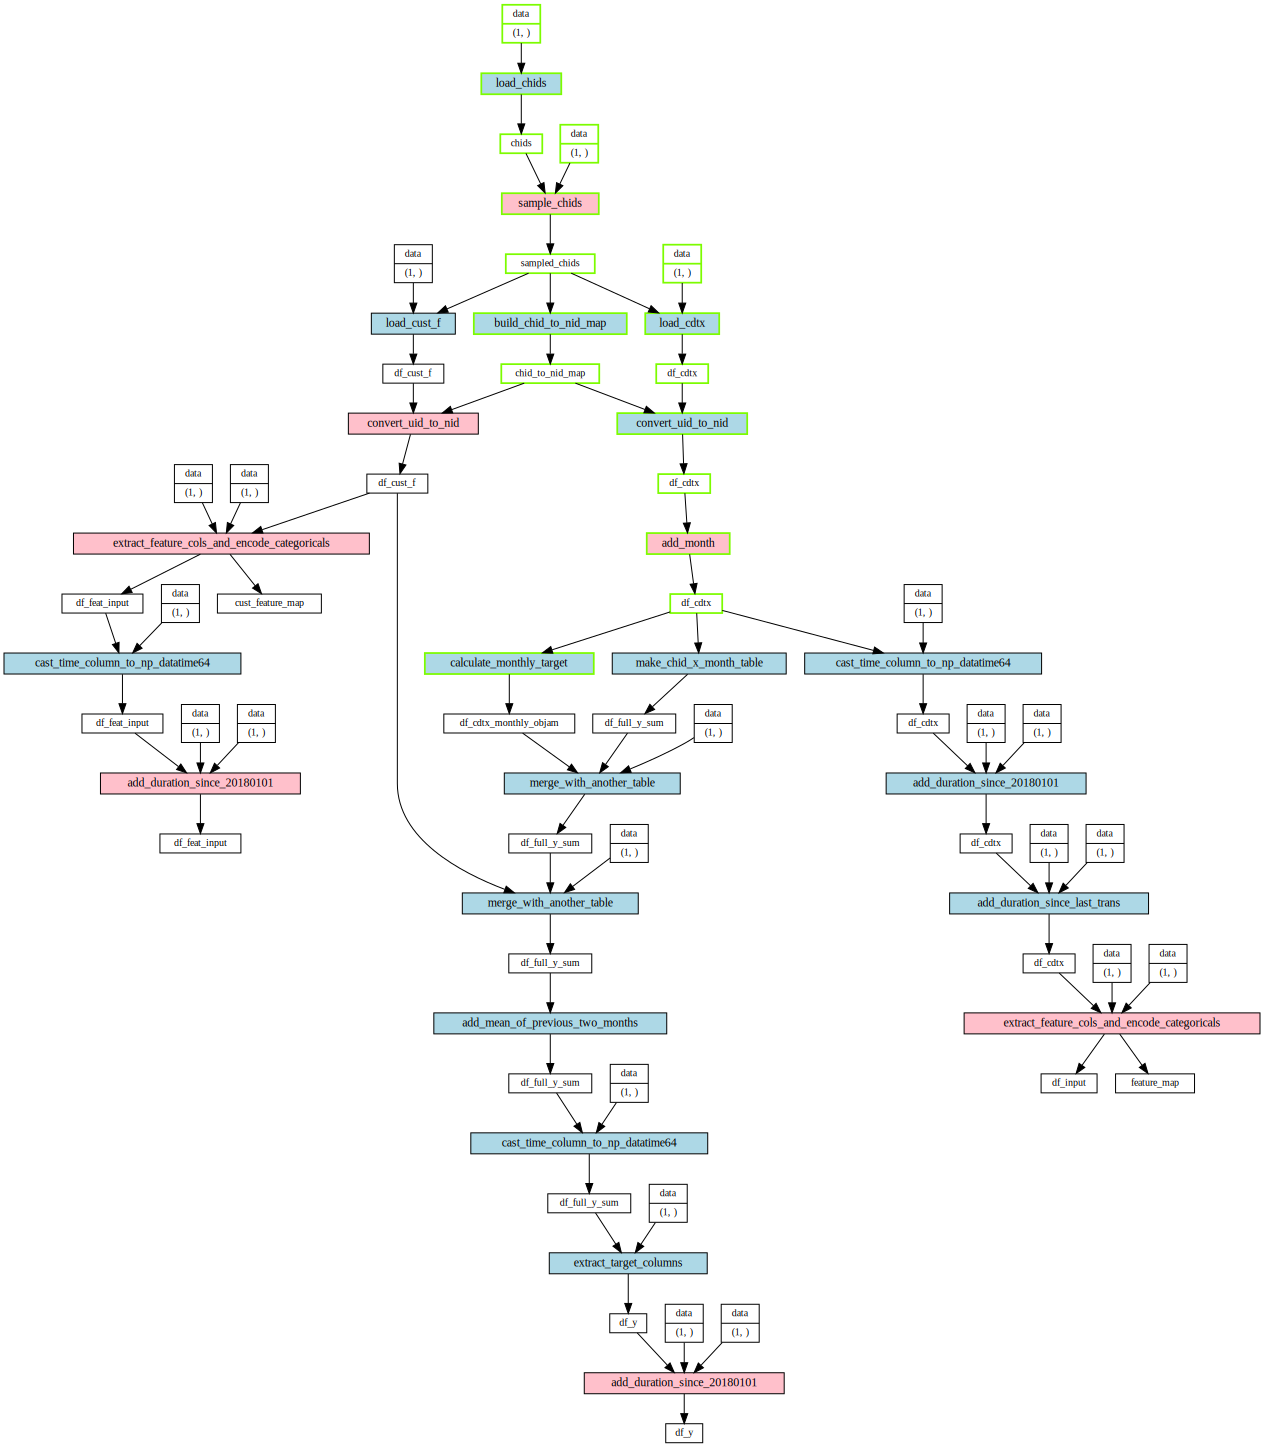

In [14]:
pipe.view_dependency('calculate_monthly_target', summary=False)

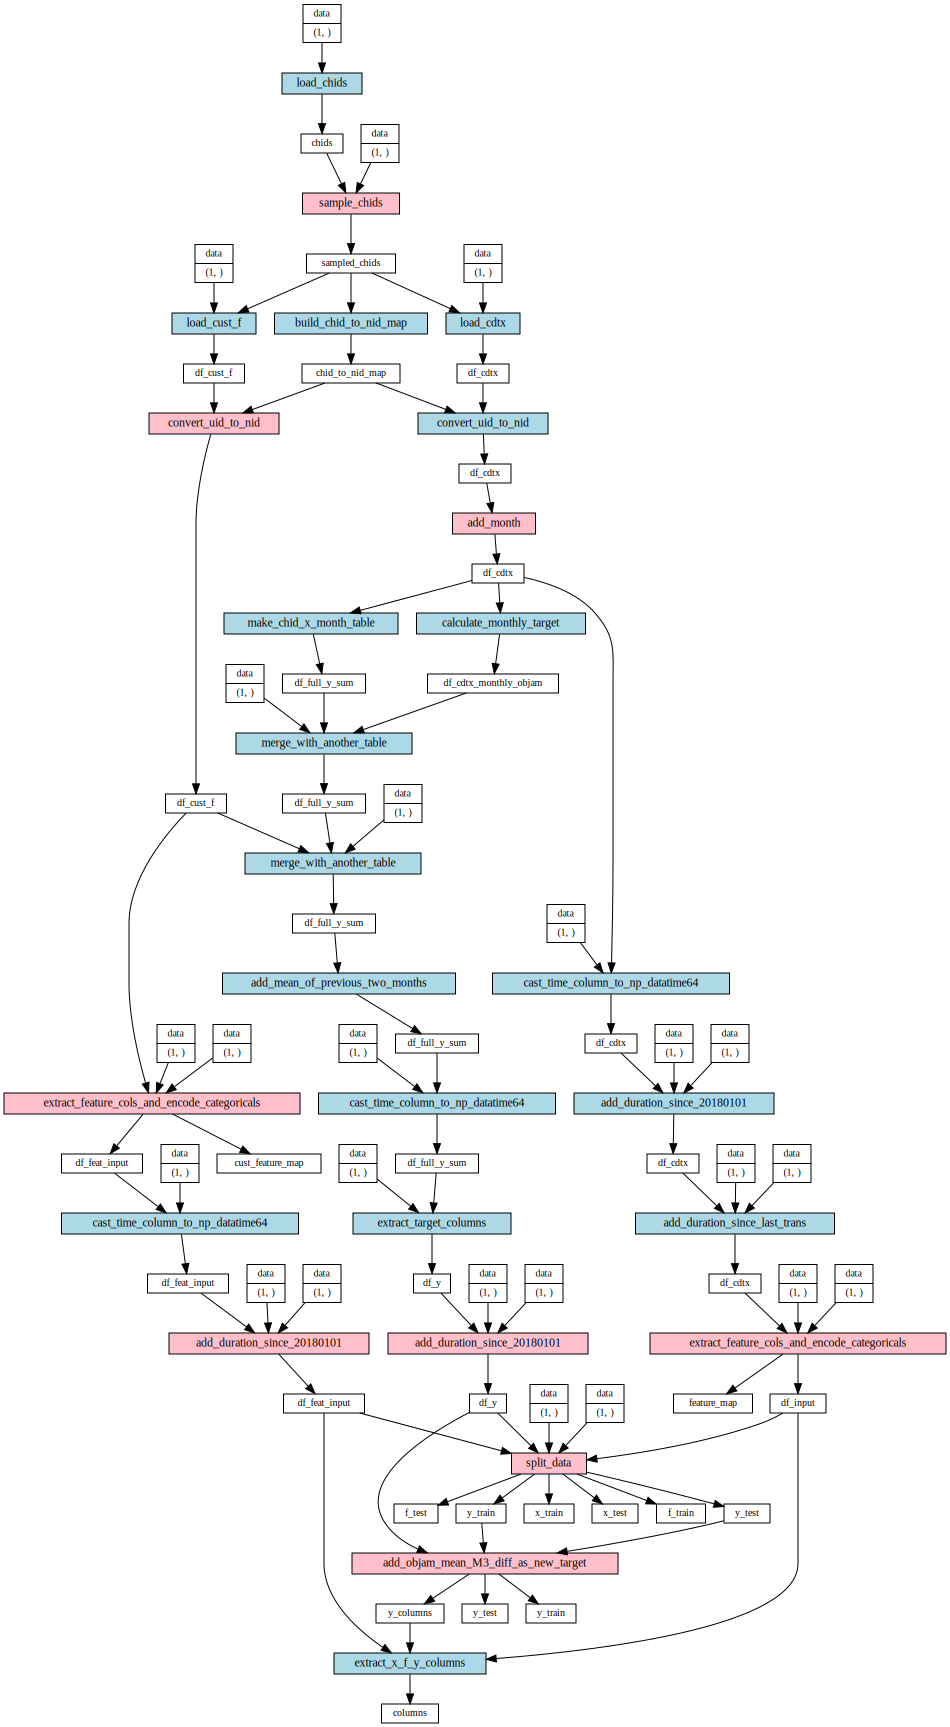

In [15]:

# split_data
# add_objam_mean_M3_diff_as_new_target
# extract_x_f_y_columns

x_train, x_test, f_train, f_test, y_train, y_test = pipe.add(
    split_data, 
    n_out = 6,
    output_alias = ['x_train', 'x_test', 'f_train', 'f_test', 'y_train', 'y_test'],
    result_dir=[
                os.path.join(tmp_path, 'x_train.npy'),
                os.path.join(tmp_path, 'x_test.npy'),
                os.path.join(tmp_path, 'f_train.npy'),
                os.path.join(tmp_path, 'f_test.npy'),
                os.path.join(tmp_path, 'y_train.npy'),
                os.path.join(tmp_path, 'y_test.npy')
            ]
)(df_input, df_feat_input, df_y, window_size = window_size, test_size = test_size)


y_train, y_test, y_columns = pipe.add(
    add_objam_mean_M3_diff_as_new_target, 
    n_out = 3,
    output_alias = ['y_train', 'y_test', 'y_columns'],
    result_dir = [
        os.path.join(tmp_path, 'y_train.npy'),
        os.path.join(tmp_path, 'y_test.npy'),
        os.path.join(tmp_path, 'y_columns.npy')
    ]
)(df_y, y_train, y_test)

columns = pipe.add(extract_x_f_y_columns, output_alias = 'columns')(
    df_input, df_feat_input, y_columns
)


'''
for output in [x_train, x_test, f_train, f_test, y_train, y_test, columns, feature_map, cust_feature_map, chid_to_nid_map]:
    output.get()
'''
pipe.view(summary=False)

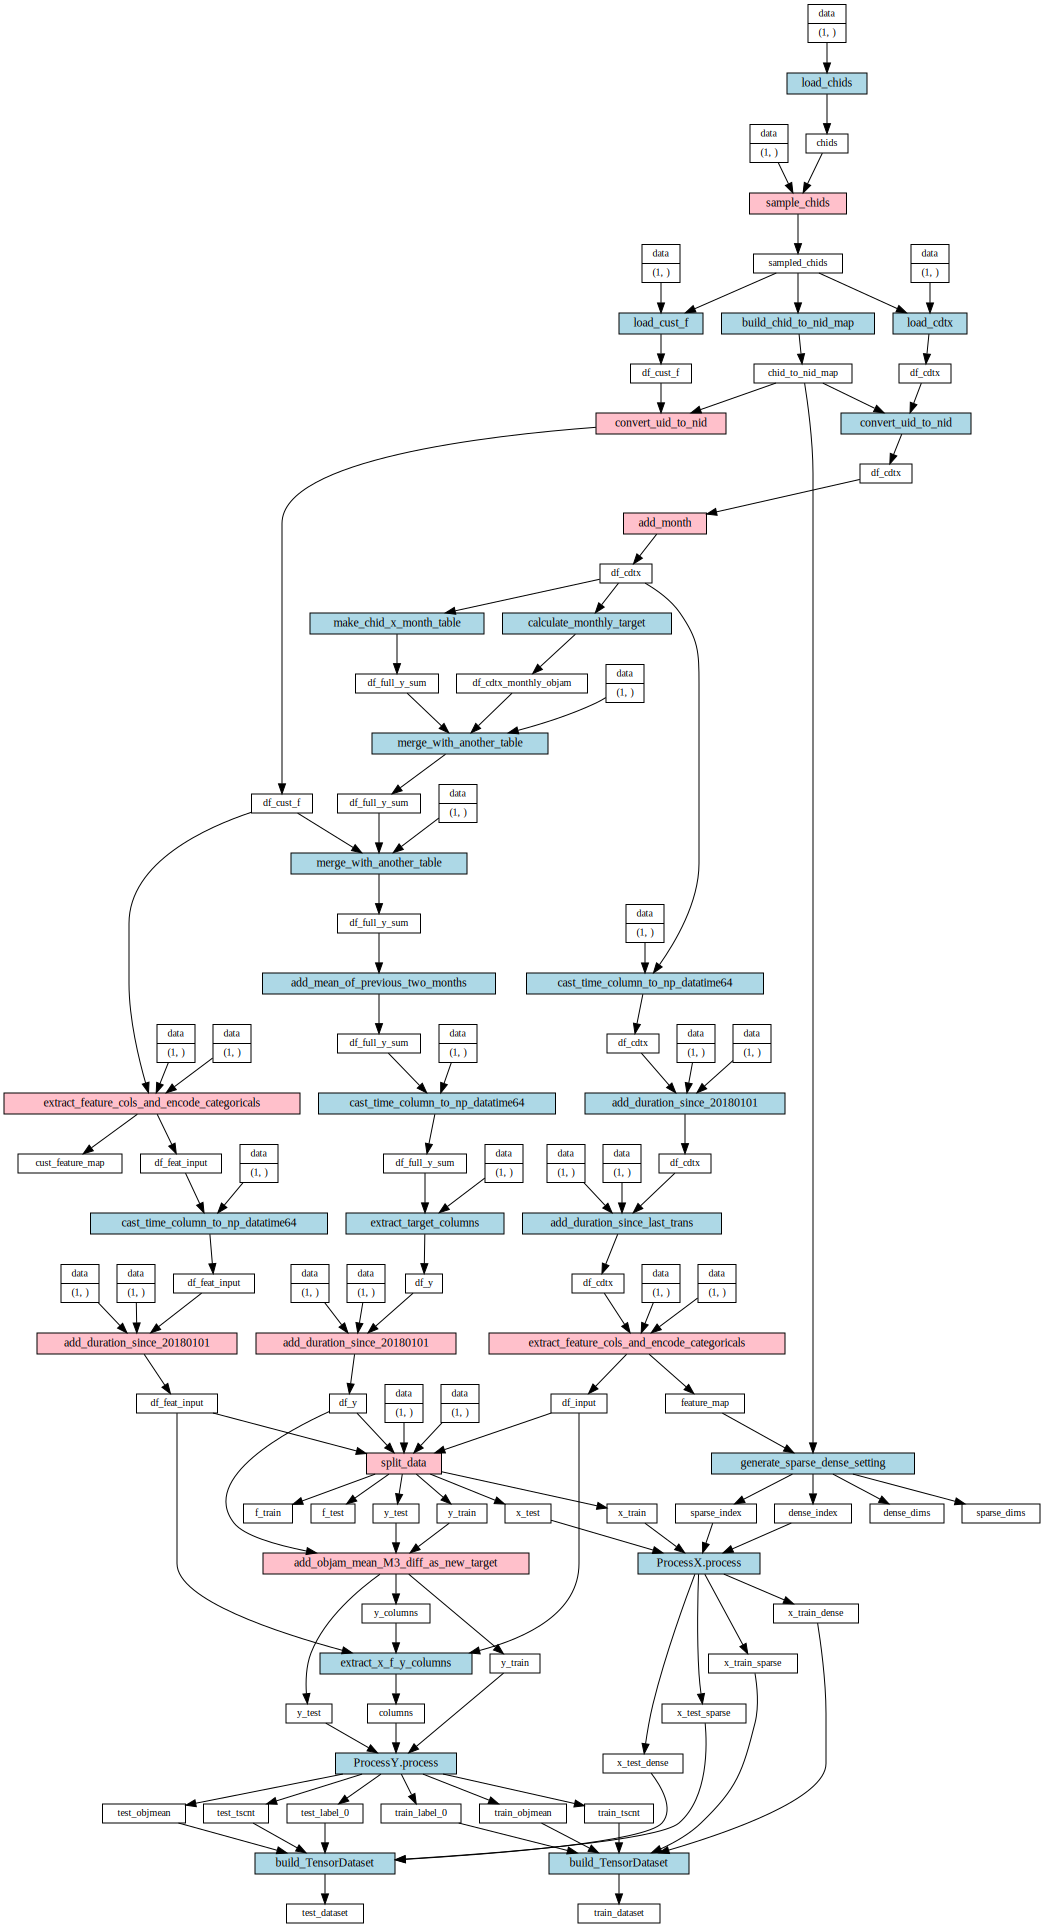

In [16]:


sparse_dims, sparse_index, dense_dims, dense_index = pipe.add(
    sparse_dense_setting_generator.process,
    method_alias = 'generate_sparse_dense_setting',
    n_out = 4, 
    output_alias = ['sparse_dims', 'sparse_index', 'dense_dims', 'dense_index']
)(
    feature_map, chid_to_nid_map
)

x_train_sparse, x_train_dense, x_test_sparse, x_test_dense = pipe.add(
    ProcessX.process,
    method_alias = 'ProcessX.process',
    n_out = 4, 
    output_alias = ['x_train_sparse', 'x_train_dense', 'x_test_sparse', 'x_test_dense']
)(
    x_train, x_test, sparse_index, dense_index
)

train_objmean, train_tscnt, train_label_0, test_objmean, test_tscnt, test_label_0 = pipe.add(
    ProcessY.process,
    method_alias = 'ProcessY.process',
    n_out = 6, 
    output_alias = ['train_objmean', 'train_tscnt', 'train_label_0', 'test_objmean', 'test_tscnt', 'test_label_0']
)(
    y_train, y_test, columns
)

train_dataset = pipe.add(
    build_TensorDataset,
    output_alias = 'train_dataset'
)(
    x_train_dense, x_train_sparse, train_objmean, train_tscnt, train_label_0
)
    
test_dataset = pipe.add(
    build_TensorDataset,
    output_alias = 'test_dataset'
)(
    x_test_dense, x_test_sparse, test_objmean, test_tscnt, test_label_0
)
pipe.view(summary=False)

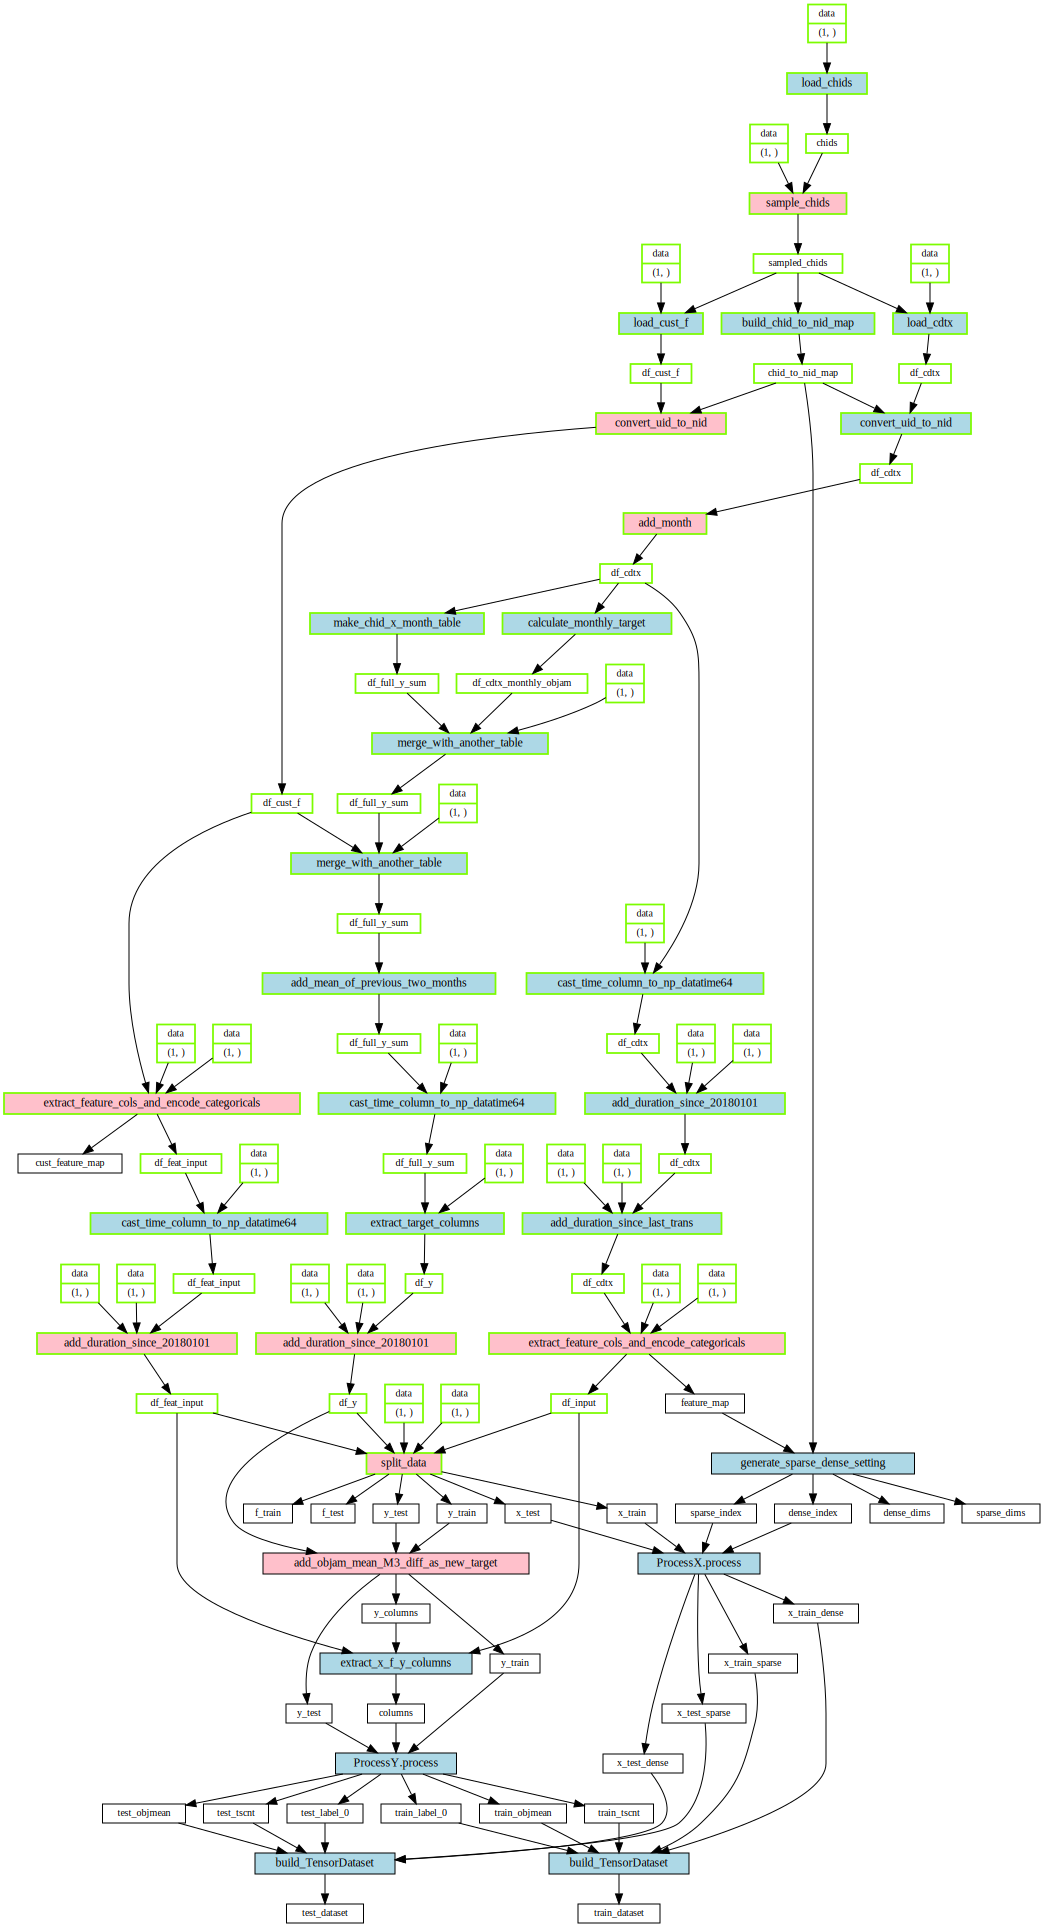

In [17]:
pipe.view_dependency('split_data', summary=False)

In [18]:
test_dataset.run(verbose=True)

[RUN] process of "process[3]"
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
[RUN] process of "process[2]"
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
[RUN] process of "process[3]"
Convert Numeric Y values to np.float64 for Regression
Apply Log(1+x) Transformation
Apply  MinMaxScaler((0,1)) to objmean
Convert ob